First we import libraries and set the random seed:

In [1]:
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torch import nn
from torch.nn import functional as F
from torch import optim
from tqdm.autonotebook import tqdm
from textwrap import wrap
import random
import sys
import io
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

torch.manual_seed(0)

The following block defines a dataset object which parses our data file and performs numericalisation of the sequence data:

In [2]:
class CodeDataset(Dataset):
    def __init__(self):
        download_url('https://github.com/ecs-vlc/COMP6248/raw/master/exercises/lab7/dataset.txt', '.', 'dataset.txt', None)
        with io.open('dataset.txt', 'r') as f:
            self.data = f.readlines()

        self.PAD='_'
        self.SOS='^'
        self.EOS='$'
        self.PAD_IDX=0

        # construct the vocabularies to numericalise the data
        self.alphabet = "*".join(self.PAD+self.SOS+self.EOS+"abcdefghijklmnopqrstuvwxyz ").split('*')

        self.alphabet_indices = dict((c, i) for i, c in enumerate(self.alphabet))
        self.indices_alphabet = dict((i, c) for i, c in enumerate(self.alphabet))

        self.morsebet = self.PAD+self.SOS+self.EOS+'.- /'
        self.morse_indices = dict((c, i) for i, c in enumerate(self.morsebet))
        self.indices_morse = dict((i, c) for i, c in enumerate(self.morsebet))

    def encode_alpha(self, inp):
        x = torch.zeros(len(inp), dtype=torch.long)
        for t, char in enumerate(inp):
            x[t] = self.alphabet_indices[char]

        return x

    def decode_alpha(self, ten, skip_tok=False):
        s = ''
        ten = ten.view(-1)
        for v in ten.view(-1):
            if not skip_tok:
                s += self.indices_alphabet[v.item()]
            elif v>2:
                s += self.indices_alphabet[v.item()]
        return s

    def encode_morse(self, inp):
        x = torch.zeros(len(inp), dtype=torch.long)
        for t, char in enumerate(inp):
            x[t] = self.morse_indices[char]

        return x

    def decode_morse(self, ten):
        s = ''
        for v in ten:
          s += self.indices_morse[v]
        return s

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        inp, out = self.data[i].strip().split('|')
        x = self.encode_morse(inp)
        y = self.encode_alpha(out[::-1])
        return x, y


# This will be used to automatically pad all batch items to the same length
def pad_collate(batch): 
    data = [item[0] for item in batch]
    data = pad_sequence(data)
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets)
    return [data, targets]

# Load the data and split randomly into training and val subsets
ds = CodeDataset()
tr, va = random_split(ds, [len(ds) - len(ds)//3, len(ds)//3])
trainloader = DataLoader(tr, batch_size=1024, shuffle=True, collate_fn=pad_collate)
valloader = DataLoader(va, batch_size=1024, shuffle=False, collate_fn=pad_collate)

We next define the model architecture, which is made up of an encoder, a decoder and the Seq2Seq class which ties everything together:

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim)
        
    def forward(self, src):
        embedded = self.embedding(src)
        _, (hidden, cell) = self.rnn(embedded)
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))        
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg=None, teacher_forcing_ratio = 0.5, maxlen=5, padding_idx=0):
        batch_size = src.shape[1]
        trg_len = trg.shape[0] if trg is not None else maxlen
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(src.device)
        hidden, cell = self.encoder(src)

        input = torch.ones(batch_size, dtype=torch.long, device=src.device) * padding_idx
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[t] if teacher_force and trg is not None else top1
        
        return outputs


INPUT_DIM = len(ds.morsebet)
OUTPUT_DIM = len(ds.alphabet)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM)
model = Seq2Seq(enc, dec).cuda()

Finally, we can train and evaluate the model:

In [8]:
crit = nn.CrossEntropyLoss(ignore_index=ds.PAD_IDX)
opt = optim.Adam(model.parameters())
train_loss = np.zeros([10])
validation_loss = np.zeros([10])

for e in range(10):
    model.train()

    with tqdm(total=len(trainloader), desc='train') as t:
        epoch_loss = 0
        for i, (x, y) in enumerate(trainloader):
            x = x.cuda()
            y = y.cuda()

            opt.zero_grad()
            pred = model(x, y, padding_idx=ds.PAD_IDX)

            pred_dim = pred.shape[-1]
            pred = pred[1:].view(-1, pred_dim)
            y = y[1:].view(-1)

            loss = crit(pred, y)
            loss.backward()
            opt.step()

            epoch_loss = (epoch_loss*i + loss.item()) / (i+1)
            train_loss[e] = epoch_loss

            t.set_postfix(loss='{:05.3f}'.format(epoch_loss))
            t.update()

    model.eval()
    with tqdm(total=len(valloader), desc='val') as t:
        with torch.no_grad():
            epoch_loss = 0
            for i, (x, y) in enumerate(valloader):
                x = x.cuda()
                y = y.cuda()

                pred = model(x, y, teacher_forcing_ratio=0, padding_idx=ds.PAD_IDX)

                pred_dim = pred.shape[-1]
                pred = pred[1:].view(-1, pred_dim)
                y = y[1:].view(-1)

                loss = crit(pred, y)
                epoch_loss = (epoch_loss*i + loss.item()) / (i+1)
                validation_loss[e] = epoch_loss

                t.set_postfix(loss='{:05.3f}'.format(epoch_loss))
                t.update()

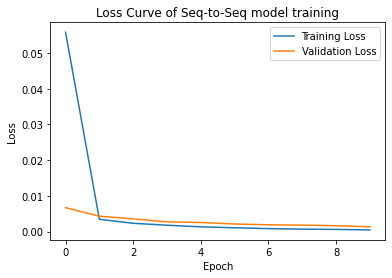

In [9]:
plt.plot([e for e in range(10)], train_loss, label="Training Loss")
plt.plot([e for e in range(10)], validation_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve of Seq-to-Seq model training")
plt.savefig("loss_curve.png")

In [0]:
def decode(code):
  out = ''
  for chunk in code.split(' '):
    num = ds.encode_morse('^ ' + chunk + ' $').unsqueeze(1)
    #print(num)
    pred = model(num.cuda(), maxlen=2)
    #print(pred.shape)
    pred_dim = pred.shape[-1]
    #print(pred[1:].view(-1, pred_dim).shape)
    pred = pred[1:].view(-1, pred_dim).argmax(-1)
    out += ds.decode_alpha(pred.cpu())[::-1]
  return out

def decode_2(code, n):
  out = ''
  for chunk in [code[i:i+n] for i in range(0, len(code), n)]: #code.split(' '):
    num = ds.encode_morse('^ ' + chunk + ' $').unsqueeze(1)
    pred = model(num.cuda(), maxlen=2)
    pred = pred[1:].view(-1, pred_dim).argmax(-1)
    out += ds.decode_alpha(pred.cpu())[::-1]
  return out


def decode_3(code):
  num = ds.encode_morse('^ ' + code + ' $').unsqueeze(1)
  pred = model(num.cuda(), maxlen=2)
  pred_dim = pred.shape[-1]
  pred = pred[1:].view(-1, pred_dim).argmax(-1)
  out = ds.decode_alpha(pred.cpu())[::-1]
  return out

def decode_4(code,n):
  out = ''
  for chunk in chunks(code.split(' '),n):
    chunk = ' '.join(chunk)
    num = ds.encode_morse('^ ' + chunk + ' $').unsqueeze(1)
    pred = model(num.cuda(), maxlen=2)
    pred_dim = pred.shape[-1]
    pred = pred[1:].view(-1, pred_dim).argmax(-1)
    out += ds.decode_alpha(pred.cpu())[::-1]
  return out


def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [0]:
code_1 = ".- -.  ...  .-- .  .-.  / - ....  .  / ..-.  --- .-..  .-..  --- .-- ..  -.  --."
code_2 = ".-- ....  -.-- / ..  ...  / - ....  .  / --- .-.  -..  .  .-.  / --- ..-.  / -....  .  / --- ..- - .--.  ..- - / .-.  .  ...- .  .-.  ...  .  -.."
code_3 = ".-- ....  .- - / ..  ...  / - ....  .  / .--.  --- ..  -.  - / --- ..-.  / - ..- -.-.  ....  .  .-.  / ..-.  --- .-.  -.-.  ..  -.  --."
output_code = decode(code_3)
print(output_code)

wh at i s  th e  p oi n t of  tuc h e r  f or c i n g


In [0]:
for x in range(1,20):
  output = decode_4(code_1, x)
  print(f"chunk length: {x} = {output}")

chunk length: 1 = an s we r  th e  f ol l owi n g
chunk length: 2 = nswe thefo  wing
chunk length: 3 = nwrtefl ing
chunk length: 4 = s teo ig
chunk length: 5 = s eoong
chunk length: 6 = wtf ng
chunk length: 7 = ehlig
chunk length: 8 = ee g
chunk length: 9 = rfig
chunk length: 10 = eo g
chunk length: 11 =   n
chunk length: 12 =   g
chunk length: 13 = hwg
chunk length: 14 =  ig
chunk length: 15 = e g
chunk length: 16 = en
chunk length: 17 =  n
chunk length: 18 = fn
chunk length: 19 =  n
